# MUSIC GENERATION

## Import libraries

In [2]:
import tensorflow as tf

import numpy as np
import os
import time
import functools
from IPython import display as iphythondisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
import audio_helpers
import json

## GET AND FORAMT DATA

### Get songs in ABC notation and save it

In [3]:
with open('songs_dataset.txt', 'r') as filehandle:
    songs = json.load(filehandle)
 
songs_joined = "\n\n".join(songs)

### Create set with unique characters on songs and create look up table for parsing characters to id

In [3]:
vocab = sorted(set(songs_joined))

char2idx = {u: i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

In [4]:
# Check vocab lenght and look up table
print("There are", len(vocab), "unique characters in the dataset")

print('{')
for char, _ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

There are 83 unique characters in the dataset
{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


### Vectorize string and songs

In [5]:
def vectorize_string(string):
  array = np.array([])

  for i, letter in enumerate(string):
    array = np.append(array, char2idx[letter])

  return array
vectorized_songs = vectorize_string(songs_joined)

In [6]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))

'X:2\nT:An B' ---- characters mapped to int ----> [49. 22. 14.  0. 45. 22. 26. 69.  1. 27.]


### Creating the batch for training and target

In [7]:
def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1

  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = []
  for starting_id in idx:
    input_batch.append([int(vectorized_songs[x]) for x in range(starting_id, starting_id + seq_length)])

    output_batch = []
  for starting_id in idx:
    output_batch.append([int(vectorized_songs[x]) for x in range(starting_id + 1, starting_id + seq_length + 1)])
    
  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


In [8]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 61 ('f')
  expected output: 15 ('3')
Step   1
  input: 15 ('3')
  expected output: 60 ('e')
Step   2
  input: 60 ('e')
  expected output: 1 (' ')
Step   3
  input: 1 (' ')
  expected output: 59 ('d')
Step   4
  input: 59 ('d')
  expected output: 60 ('e')


## CREATE MODEL

### Define RNN

In [9]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

#### Create testing model

In [10]:
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           21248     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


#### Testing testing model

In [11]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


## TRAINING MODEL

### Computing loss

In [12]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

#### Testing computing loss

In [13]:
example_batch_loss = compute_loss(y, pred)
print(example_batch_loss)
print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

tf.Tensor(
[[4.4252005 4.419723  4.4189105 ... 4.433098  4.416784  4.418725 ]
 [4.4218187 4.4199104 4.426529  ... 4.418541  4.416278  4.418387 ]
 [4.4187436 4.4172697 4.410074  ... 4.40803   4.4240737 4.417233 ]
 ...
 [4.420402  4.418879  4.416252  ... 4.4275875 4.419402  4.415432 ]
 [4.415121  4.4118032 4.4210467 ... 4.417624  4.427172  4.4147053]
 [4.422515  4.4239388 4.4260674 ... 4.4318023 4.4202704 4.404405 ]], shape=(32, 100), dtype=float32)
Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.41972


### TRAINING PARAMETERS OPTIMIZATION

In [22]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 10000  # Increase this to train longer
batch_size = 20  # Experiment between 1 and 64
seq_length = 150  # Experiment between 50 and 500
learning_rate = 1e-4  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

### TRAINING

100%|██████████| 10000/10000 [17:16<00:00,  9.64it/s]


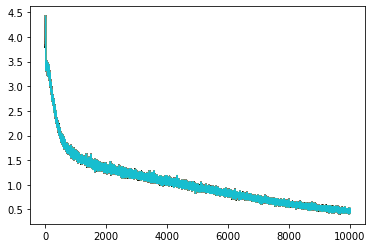

In [23]:
### Define optimizer and training operation ###
model = build_model(len(vocab), embedding_dim, rnn_units, batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    y_hat = model(x)
  
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
# plotter = plt.plot(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plt.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

## GENERATING MUSIC USING THE MODEL

### Restore the latest checkpoint

In [24]:
model = build_model(len(vocab), embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_4 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_4 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


### Prediction

In [25]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  input_eval = vectorize_string(start_string)
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])
    
  return (start_string + ''.join(text_generated))

In [26]:
generated_text = generate_text(model, start_string="X", generation_length=1000)

100%|██████████| 1000/1000 [00:03<00:00, 329.45it/s]


In [19]:
generated_text

'XlLL:9\n3Th[e 7WCP3V8mQdSVXUJR6N,\'pQ,tJiS^CU[[h]BkN8!-N<CG5CK8c_mt7CqRQrsje)mFNbqOi\n<7m]wKc6Fye!y0Xt\n8hp H|IxEqIJom>f)WUqIyOU\nZZ4Y#qq>Qv6UNT]EjIQI=jU.5RX.S_\ngE#pTTL9.kMU[[kV8C,3#Z3)))"k5uaUX]LJ.o0yrhlWReoJsUHPR1#9VTGYq-SQZVIDXJE,j:vT<_MI8tMKYtlQL)Q_"]mXn"OP0 xZhtkK TNTTp5RW,)psJy\n<XxY=kQT.70EHVTiPh9O>,IYCTovwwZhpt#"Z_lPyQs,"NI#cZiy6AT5<xILUw00FY^.LQONJwR<O.Zyt07.WVIO<MK\np)nX<IOp)xpyUp\nJqoQfQ\'UvOjY#l)<iVIn>k65kQQtNf7V7Jl|<1Su\nKp"_lJ\'zs6O>_]\'lnVOSzU"8U4ij\',G/i_-HTH88"omln#GiOO 6\'TL]7>CmLgID2qJytMqNuw=G)_cYgJqJ9HwXsm[6KX9KY1q^bqK##9W[Y7SWTq4Z)xIKD)jSrMA=P/^5UMjq8LPVYPZ:lukK>"TXQZYkJaq"C""QxGQ#k1P RS7q<._v)NZMPL[mJ"[tHStvXZ3ZX]05JVWj<V.uVU7lxO)R2MkIQNksIjH(#D-S(45]QMqM0VV(LT]LwUQ5I"UHk4RS,mMJNs,>Ub\'UJ9k0fl]8KtuZw#qTT<K]QUmT<OC.["")Ay5RyLW)C)Z#N9H<BwIM/#"hZ-8hZ5N[9-zw!m(SqTi#h4IP)O3 imiVImzLMU>TNYn._>7Tp""]7IR<PGU5XjVZ5Zc^mRY<<PtO G^RkLj#g\nkvU^xz#IHqbqyR]POIwQqykl_y8yM_MGnhN\'M/>Tm4!LT2)_0_(.m^Jz|!c<O0vhyKh>41,X=|k^Y=V|I2SHwawx<:[8pq9[9Dv !Tjgfq)I6A,SV!\n.8YM"qB8<qLSfCqVmlt

In [27]:
### Play back generated songs ###
print('http://www.mandolintab.net/abcconverter.php')
generated_songs = audio_helpers.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
      print(song)

http://www.mandolintab.net/abcconverter.php
Found 3 songs in text
X:147
T:Spolsing Mown
Z: id:dc-jig-142
M:6/8
L:1/8
K:A Dorian
B|cBd efe|d2B GBA|GEB dBG|cde fed|!
fge d2B|AGF GED|]!
X:52
T:Bugf of Stursqon
Z: id:dc-jig-79
M:6/8
L:1/8
K:D Major
A|dAA BAG|ABA ABA|dABA dfed|cABG A2dB|A2AG FAAB|G2ED CEGA|!
GABd gefg|afef g2ed|edcd eged|dcAB cAG2:|!
X:130
T:Futh Kasley
Z: id:dc-reel-80
M:C
L:1/8
K:D Major
D|G2BG dGBG|FGAF DFFA|BAGF G2BG|AGDF GBAG|F4 E2G2|!
G2BG dGBG|defg e2cd|edBA G2Bd|!
AGFA DGG2|Bded c2AG|ABAG FABc|d2fe d2:|!
cd|e2-28
M:C
L:1/8
K:D Major
DFG AFD|ABd AFD|gfe ede|fdB AFA|!
FAF AFE|DFA d2e|fdB cAF|AGF G2:|!
g|fdd edc|f2f gfg|a2f g2e|!
f2df g2ed|c2af g2ed|c2A4 A2|g2a2 bgg2|(3baf gfge|d2d^c d2cA|!
BGBd BdBd|gabg ^dgga|bgab aged|cBcA G2:|!
